# Task 1

In [1]:
!nvidia-smi
!nvcc --version

Wed Feb  4 17:49:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## task 2 and 3 file making

In [2]:
import random

def createRandomMatrices(filename, rows, cols, max_val=100):
    with open(filename, 'w') as f:
        f.write(f"{rows} {cols}\n")

        matrix_A = [str(random.randint(0, max_val)) for _ in range(rows * cols)]
        f.write(" ".join(matrix_A) + "\n")

        matrix_B = [str(random.randint(0, max_val)) for _ in range(rows * cols)]
        f.write(" ".join(matrix_B) + "\n")

createRandomMatrices("input.txt", 2, 2, 10)
print("input.txt created successfully!")

input.txt created successfully!


# task 2

In [3]:
!mkdir task02

mkdir: cannot create directory ‘task02’: File exists


In [4]:
%cd task02

/content/task02


## task 2 cpp file


In [5]:
%%writefile task02.cpp
#include <iostream>
#include <vector>
#include <fstream>
#include <string>
#include <stdexcept>
#include <chrono>

void readInput(const std::string& filename, int& rows, int& cols,
               std::vector<int>& A, std::vector<int>& B) {
    std::ifstream infile(filename);
    if (!infile) throw std::runtime_error("Error: Could not open input file.");
    if (!(infile >> rows >> cols)) throw std::runtime_error("Error: Reading dims.");

    int size = rows * cols;
    A.resize(size);
    B.resize(size);
    for (int i = 0; i < size; ++i) infile >> A[i];
    for (int i = 0; i < size; ++i) infile >> B[i];
}

void addMatrices(int rows, int cols, const std::vector<int>& A,
                 const std::vector<int>& B, std::vector<int>& C) {
    int size = rows * cols;
    C.resize(size);
    for (int i = 0; i < size; ++i) {
        C[i] = A[i] + B[i];
    }
}

void writeOutput(const std::string& filename, int rows, int cols,
                 const std::vector<int>& C) {
    std::ostream* out = &std::cout;
    std::ofstream outfile;
    if (!filename.empty()) {
        outfile.open(filename);
        if (!outfile) throw std::runtime_error("Error: Could not open output file.");
        out = &outfile;
    }
    *out << rows << " " << cols << "\n";
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            *out << C[i * cols + j] << " ";
        }
        *out << "\n";
    }
}

int main(int argc, char* argv[]) {
    try {
        if (argc < 2) {
            std::cerr << "Usage: " << argv[0] << " <input_file> [output_file]\n";
            return 1;
        }

        std::string inputObj = argv[1];
        std::string outputObj = (argc >= 3) ? argv[2] : "";

        int rows, cols;
        std::vector<int> A, B, C;

        readInput(inputObj, rows, cols, A, B);

        // --- TIMER START ---
        auto start = std::chrono::high_resolution_clock::now();

        addMatrices(rows, cols, A, B, C);

        auto end = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = end - start;
        std::cerr << elapsed.count() << "\n";
        // --- TIMER END ---

        writeOutput(outputObj, rows, cols, C);

    } catch (const std::exception& e) {
        std::cerr << e.what() << "\n";
        return 1;
    }
    return 0;
}

Overwriting task02.cpp


## task 2 make file


In [6]:
%%writefile Makefile
CXX = g++
CXXFLAGS = -Wall -Wextra -std=c++17

all: matadd_cpu

matadd_cpu: task02.cpp
	$(CXX) $(CXXFLAGS) -o matadd_cpu task02.cpp

clean:
	rm -f matadd_cpu

Overwriting Makefile


## run task 2

In [7]:
!make clean
!make
!./matadd_cpu ../input.txt output_cpu.txt

!cat ../input.txt

!cat output_cpu.txt

rm -f matadd_cpu
g++ -Wall -Wextra -std=c++17 -o matadd_cpu task02.cpp
0.000902
2 2
4 9 0 3
0 10 8 0
2 2
4 19 
8 3 


# Task 3

In [8]:
%cd ..

/content


In [9]:
!mkdir task03

mkdir: cannot create directory ‘task03’: File exists


In [10]:
%cd task03

/content/task03


## task3 .cu file

In [11]:
%%writefile task03.cu
#include <iostream>
#include <vector>
#include <fstream>
#include <string>
#include <stdexcept>
#include <cuda_runtime.h>
#include <chrono>

__global__ void addKernel(const int* A, const int* B, int* C, int size) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < size) {
        C[i] = A[i] + B[i];
    }
}

void checkCuda(cudaError_t result, const char* func) {
    if (result != cudaSuccess) {
        std::cerr << "CUDA Error in " << func << ": " << cudaGetErrorString(result) << std::endl;
        exit(1);
    }
}

void readInput(const std::string& filename, int& rows, int& cols,
               std::vector<int>& A, std::vector<int>& B) {
    std::ifstream infile(filename);
    if (!infile) throw std::runtime_error("Error: Could not open input file.");
    if (!(infile >> rows >> cols)) throw std::runtime_error("Error: Reading dims.");

    int size = rows * cols;
    A.resize(size);
    B.resize(size);
    for (int i = 0; i < size; ++i) infile >> A[i];
    for (int i = 0; i < size; ++i) infile >> B[i];
}

void writeOutput(const std::string& filename, int rows, int cols,
                 const std::vector<int>& C) {
    std::ostream* out = &std::cout;
    std::ofstream outfile;
    if (!filename.empty()) {
        outfile.open(filename);
        if (!outfile) throw std::runtime_error("Error: Could not open output file.");
        out = &outfile;
    }
    *out << rows << " " << cols << "\n";
    for (int i = 0; i < rows; ++i) {
        for (int j = 0; j < cols; ++j) {
            *out << C[i * cols + j] << " ";
        }
        *out << "\n";
    }
}

void addMatricesGPU(int rows, int cols, const std::vector<int>& h_A,
                    const std::vector<int>& h_B, std::vector<int>& h_C) {
    int size = rows * cols;
    size_t bytes = size * sizeof(int);
    h_C.resize(size);

    int *d_A, *d_B, *d_C;
    checkCuda(cudaMalloc(&d_A, bytes), "cudaMalloc A");
    checkCuda(cudaMalloc(&d_B, bytes), "cudaMalloc B");
    checkCuda(cudaMalloc(&d_C, bytes), "cudaMalloc C");

    checkCuda(cudaMemcpy(d_A, h_A.data(), bytes, cudaMemcpyHostToDevice), "Memcpy H2D A");
    checkCuda(cudaMemcpy(d_B, h_B.data(), bytes, cudaMemcpyHostToDevice), "Memcpy H2D B");

    int threadsPerBlock = 256;
    int blocksPerGrid = (size + threadsPerBlock - 1) / threadsPerBlock;
    addKernel<<<blocksPerGrid, threadsPerBlock>>>(d_A, d_B, d_C, size);

    checkCuda(cudaGetLastError(), "Kernel Launch");
    checkCuda(cudaDeviceSynchronize(), "Kernel Sync");

    checkCuda(cudaMemcpy(h_C.data(), d_C, bytes, cudaMemcpyDeviceToHost), "Memcpy D2H C");

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

int main(int argc, char* argv[]) {
    try {
        if (argc < 2) {
            std::cerr << "Usage: " << argv[0] << " <input_file> [output_file]\n";
            return 1;
        }

        std::string inputObj = argv[1];
        std::string outputObj = (argc >= 3) ? argv[2] : "";

        int rows, cols;
        std::vector<int> h_A, h_B, h_C;

        readInput(inputObj, rows, cols, h_A, h_B);

        // --- TIMER START ---
        auto start = std::chrono::high_resolution_clock::now();

        addMatricesGPU(rows, cols, h_A, h_B, h_C);

        auto end = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = end - start;
        std::cerr << elapsed.count() << "\n";
        // --- TIMER END ---

        writeOutput(outputObj, rows, cols, h_C);

    } catch (const std::exception& e) {
        std::cerr << e.what() << "\n";
        return 1;
    }
    return 0;
}

Overwriting task03.cu


## task 3 make file

In [12]:
%%writefile Makefile
NVCC = nvcc
NVCCFLAGS = -arch=sm_75 -Xcompiler -Wall,-Wextra

all: matadd_gpu

matadd_gpu: task03.cu
	$(NVCC) $(NVCCFLAGS) -o matadd_gpu task03.cu

clean:
	rm -f matadd_gpu

Overwriting Makefile


## run task 3

In [13]:
!make clean
!make
!./matadd_gpu ../input.txt output_gpu.txt

!cat ../input.txt

!cat output_gpu.txt

rm -f matadd_gpu
nvcc -arch=sm_75 -Xcompiler -Wall,-Wextra -o matadd_gpu task03.cu
206.767
2 2
4 9 0 3
0 10 8 0
2 2
4 19 
8 3 


# task 4

In [14]:
%cd ..

/content


## task 4 python script

Running N=2
Running N=4
Running N=16
Running N=64
Running N=100
Running N=500
Running N=1000
Running N=2000
Running N=5000
Running N=10000
Plot saved to task04_plot.png


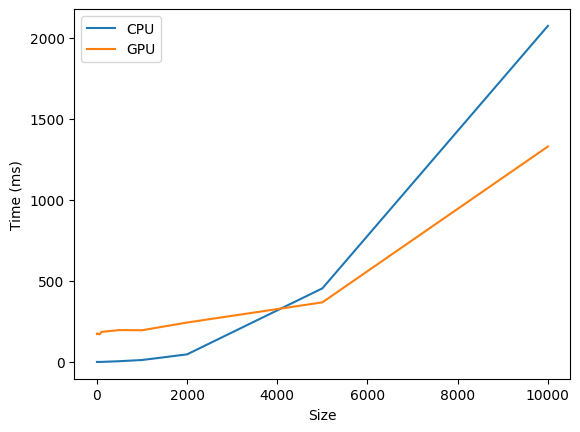

In [15]:
import subprocess
import matplotlib.pyplot as plt

sizes = [2, 4, 16, 64,100, 500, 1000, 2000, 5000, 10000]
cpu_times = []
gpu_times = []

for n in sizes:
    print(f"Running N={n}")
    createRandomMatrices("temp.txt", n, n)

    # Run CPU
    res_cpu = subprocess.run(["task02/matadd_cpu", "temp.txt"], capture_output=True, text=True)
    cpu_times.append(float(res_cpu.stderr.strip().splitlines()[-1]))

    # Run GPU
    res_gpu = subprocess.run(["task03/matadd_gpu", "temp.txt"], capture_output=True, text=True)
    gpu_times.append(float(res_gpu.stderr.strip().splitlines()[-1]))

# Plot
plt.plot(sizes, cpu_times, label='CPU')
plt.plot(sizes, gpu_times, label='GPU')
plt.xlabel('Size')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('task04_plot.png')
print("Plot saved to task04_plot.png")

## findings:
gpu only performs better in this case for matrices of size roughly greater than 4000. cpu run time grows exponentially after 2000, while gpu run time seems to grow a noticeably slower. though for smaller sizes (less than 2000), the overhead for gpu compute makes it worse.